# End-to-end Multiclass Dog Classification

This notebook builds an end-to-end Multi-class image
classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1. Problem 
Identifying the breed of the dog given an image of dog

When I'm sitting at the cafe and I take a photo of a dog, I want to know breed of dog it is.

## 2. Data

The data w'are using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probablities for a dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


## 4.Features

Some information about the data:
* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set(these images have labels)
* There are around 10,000+ images in the test set (these images have no label ,because we'll want to predict them)

In [1]:
#Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

Get our workspace ready

* Import Tensorflow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [2]:
# Import Tensorflow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version",tf.__version__)
print("TF  hub version",hub.__version__)

# Check for GPU availability
print("GPU","available (YESSSSS!!!!)" if tf.config.list_physical_devices else "not available:(")

TF version 2.2.0
TF  hub version 0.8.0
GPU available (YESSSSS!!!!)


# Getting our data ready (Turning into data)

Wirh all machine learning model our data is to be in numerical format. Turning our images into Tensors(from images to tensors(numerical representation))

Let's start by accessing our data and checking out the labels


In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     3a3d8942f7014c126c0c1bf176d0d1a3  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


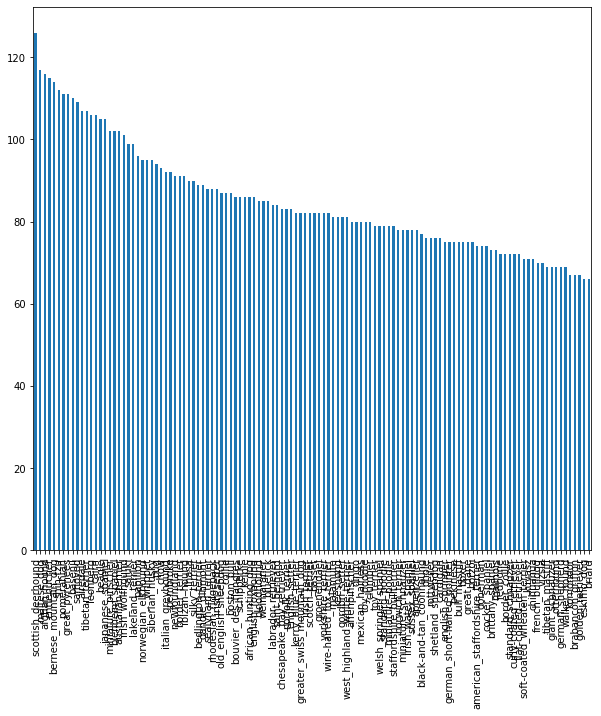

In [4]:
labels_csv["breed"].value_counts().plot.bar(figsize=(10,10))

In [5]:
labels_csv["breed"].value_counts().median()

82.0

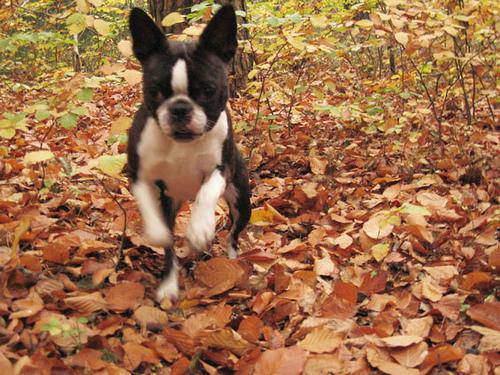

In [6]:
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames.

In [7]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg"for fname in labels_csv['id']]

# Check the filename
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files,check the target directory")


Filenames match actual amount of files!!! Proceed.


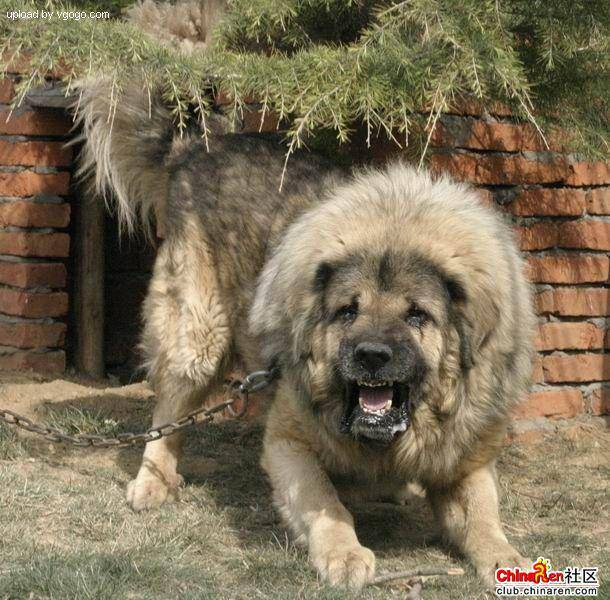

In [9]:
 # One more check
 Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list,let's prepare our labels.

In [11]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does smae thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:

len(labels)

10222

In [13]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Numbers of labels matches number of filenames")
else:
  print("Numbe of labels does not matches number of filenames, check data directories")

Numbers of labels matches number of filenames


In [14]:

# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [15]:



# Turn a single label into an array of boolean
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every labels into a boolean array
boolean_labels = [labels == unique_breeds for labels in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels),len(labels)

(10222, 10222)

In [18]:
# Example Turning boolean array into integers
print(labels[0]) # original labels
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [19]:
 print(labels[2])
 print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Create our own validation set
Since the dataset from kaggle doesn't come with a validation set,we're going to create our own.

In [20]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [21]:
len(filenames)

10222

We're going to start oof experimenting with 1000 images and increase as needed

In [22]:
# Set number of image to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider" , min:1000 , max:10000 , step:1000}

In [23]:
# Let's split our data into train and validation
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)  

(800, 800, 200, 200)

In [24]:
# Let's have a geez at the training data
X_train[:5],y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing images (turning images into Tensors) 

To preprocess our images into Tensor's we're going to write a fucntion which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, 'image'
3. Turn ou 'image ' (a jpg) into Tensors
4. Resize the 'image' to be a shape of (224,224)
5. Returns the modified 'images'

Before we do,let's see what importing images look like.

In [25]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [26]:
image.max(),image.min()

(255, 0)

In [27]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [28]:
# Turn iamge into tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what image looks like in Tensor, lets make a function to preprocess them



In [29]:
# Define image size
IMG_SIZE=224

# Create function for preprocessing images
def process_image(image_path,img_size=IMG_SIZE):
  """
  Take an image path and turns the image to tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image to numerical Tensors with 3 colors channnels (Red,Green,Blue)
  image = tf.image.decode_jpeg(image,channels=3)
  # Convert the color channel values from 0 -255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image,size=[IMG_SIZE, IMG_SIZE])

  return image

# Turning out data into batches

Why tur our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).


In order to Tensorflow effectively, we neec our data in the form of Tensor tuples which look like this.
'(image,label)' .

In [30]:
# Create a simple function to return a tuple (image,label)

def get_image_label(image_path,label):
  """
  Takes an image file path names and associate label,
  preprocess the image returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image, label

In [31]:
# Demo the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: '(image, label', let's make a function to turn all of our data (X & y) into batches!

In [32]:
# Define the batch size,32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  """
  Create batches of data out of image (X) and label(y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if its validation data.
  Also accepts test data as input (no labels).
  """
  # It the data is test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

    # if the data is valid dataset , we don't need to shuffle it
  elif valid_data:

    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                                tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch  

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                 tf.constant(y)))   
    # Shuffling pathnames and labels before mapping  image processor fucntion is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))  
    # create (image,label) tuple (thsi also turn the image path into preprocessed image)
    data =data.map(get_image_label)  

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

                     

In [33]:
# Create training data and validation data
train_data =  create_data_batches(X_train,y_train)
valid_data = create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of our data
train_data.element_spec,valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [35]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Visualizing data batches

Our data is now in batches,however , these cab be little hard to understand/comprehend, let's visualize them 

In [36]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their label from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1) 
    # Display an image    # Display an image

    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()]) 
    # Turn the grid lines off
    #plt.axis("off")


In [37]:
unique_breeds[y[0].argmax()]

'boston_bull'

# New Section

In [38]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images,train_labels

(array([[[[1.20383941e-01, 2.02736884e-01, 3.89413573e-02],
          [2.30209269e-02, 1.02677479e-01, 0.00000000e+00],
          [2.09814116e-01, 2.90452152e-01, 1.48802832e-01],
          ...,
          [2.17147902e-01, 2.75983095e-01, 2.05161825e-01],
          [1.47304282e-01, 2.17665017e-01, 1.32073015e-01],
          [8.58792141e-02, 1.63458571e-01, 6.79754019e-02]],
 
         [[5.96416704e-02, 1.38668284e-01, 1.66089851e-02],
          [1.18569605e-01, 1.97561666e-01, 5.79948984e-02],
          [1.35436043e-01, 2.11328119e-01, 8.05006325e-02],
          ...,
          [1.28604472e-01, 1.79206282e-01, 1.24420404e-01],
          [2.19684988e-01, 2.85175622e-01, 2.11106390e-01],
          [2.24808931e-01, 2.94224083e-01, 2.11468786e-01]],
 
         [[1.96863666e-01, 2.68481076e-01, 1.63738862e-01],
          [2.11056218e-01, 2.80607611e-01, 1.80423662e-01],
          [3.48314233e-02, 7.93232918e-02, 2.65615508e-02],
          ...,
          [1.80303119e-02, 5.58583699e-02, 1.6695

In [39]:
len(train_images),len(train_labels)

(32, 32)

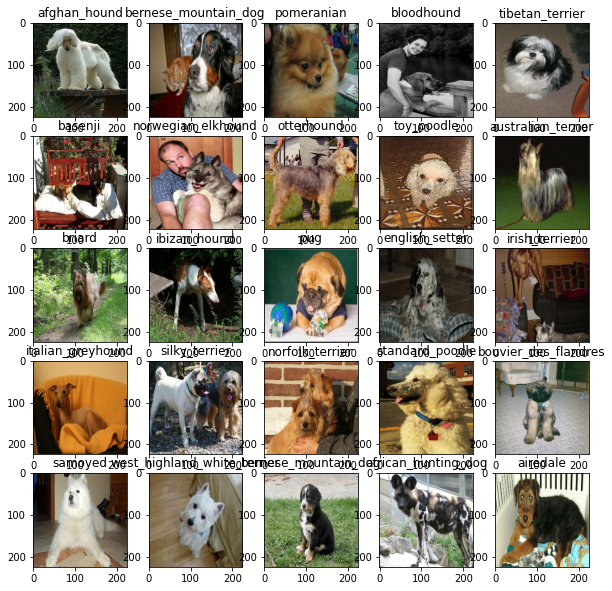

In [40]:
# Now let's visualize the data in a training batch
show_25_images(train_images,train_labels)

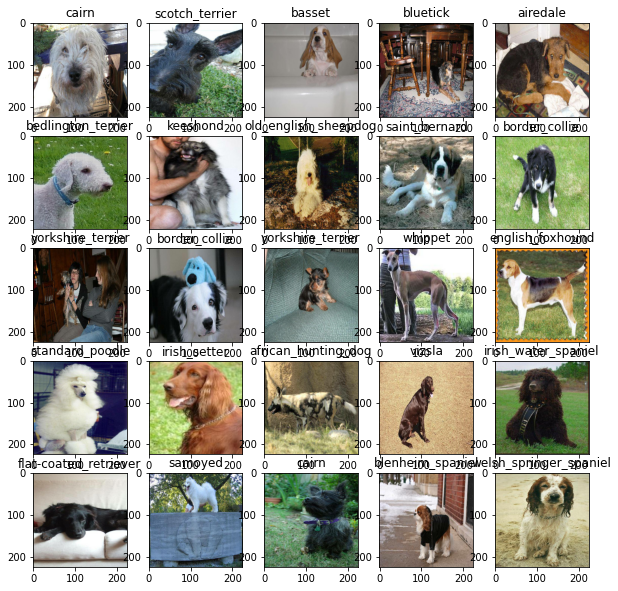

In [41]:
# Now let's visualize our validation set
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a model 
 
 Before we build a model, there are a few things we need to define
 * The input shape (our image shape, in the fomr of the tensros) to our model
 * The output shape (image label,in the form of Tensors) of our models
 * The URL of the model to use.
 https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [42]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE,3] # batch,height,width,color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got out input ,outputs and model ready to go.Let's put them together into a keras deep learning models!

knowing this, let's create & function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a keras in a sequnetial function (do this first,then this,then that ).
* Compiles the model (says it should be evaluated and improved)
* Builds the model the input shape it will be getting.
* Returns the model.

All the steps can be found here.
https://www.tensorflow.org/guide/keras/overview


In [43]:
# Create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with:",MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL),
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layers 2(output layers)
  ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [44]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [45]:
x = tf.ones((1,4))
x

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 1., 1., 1.]], dtype=float32)>

In [46]:
output = np.ones(shape=(1,1,1280))
output

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Create callbacks

Callback are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if model a model stops training 

We'll create two callbacks,one for Tensorboard which helps track our models progress and another for early stopping which prevents our model training  for too long.

### Tensorboard Callback
To setup a Tensorboard callback , we need to do 3 things
1. Load the Tensorboard notebook extension.
2. Create a Tensorboard callback which is able to save logs to a directory and pass it to our model's 'fit()' function.
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [47]:
## Load Tensorboard notebook extension
%load_ext tensorboard

In [48]:
import datetime

# Create a function to build a Tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing logs
  logdir = os.path.join("drive/My Drive/Dog Vision/log",
                        # Make it so logs get tracked wherever we run an experiment.
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


# Early stoping callback

Early stopping helps stop our model by stopping training if a certain evaluation metric stops.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [49]:
# Create early stopping model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

Training a model(on subset of data)

Our first model is going to train on 1000 images, to make sure everything is working.

In [50]:
NUM_EPOCHS = 100 #@param {type:"slider",min:10,max:100,step:10}

In [51]:
# Check to make sure we're still running on a GPU
print("GPU" , "available (YES!!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YES!!!!!)


Let's create a function which trains a model

* Create a model using 'create_model()'
* Setup a TensorBoard callback using "create_tensorboard_callback"
* Call the 'fit' function onour model passing it the training data,validation data, number of epochs to train for {'NUM_EPOCHS'} and the callbacks we'ed like to use.
* Return the model.

In [52]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained model
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 666s 27s/step - loss: 4.6394 - accuracy: 0.0938 - val_loss: 3.4189 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 6s 228ms/step - loss: 1.6854 - accuracy: 0.6625 - val_loss: 2.1927 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 6s 226ms/step - loss: 0.5843 - accuracy: 0.9337 - val_loss: 1.6925 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 6s 229ms/step - loss: 0.2561 - accuracy: 0.9900 - val_loss: 1.5173 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 6s 228ms/step - loss: 0.1481 - accuracy: 0.9975 - val_loss: 1.4462 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 6s 229ms/step - loss: 0.1019 - accuracy: 0.9987 - val_loss: 1.3952 - val_accuracy: 0.6200
Epoch 7/100
25/25 [==============================

### Checking the TensorBoard logs

The Tensorboard magic function ('%tensorboard') will access the logs directory we created earlier and visualize its content

In [53]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/log

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [54]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(valid_data,verbose=1)
predictions

7/7 [==============================] - 79s 11s/step


array([[0.00820088, 0.02923428, 0.00167206, ..., 0.00488299, 0.00195453,
        0.00013707],
       [0.00427242, 0.01000963, 0.02462036, ..., 0.00322745, 0.02011262,
        0.00144808],
       [0.03378144, 0.0214547 , 0.00090356, ..., 0.00745568, 0.01832954,
        0.0213911 ],
       ...,
       [0.00379439, 0.03516296, 0.00026687, ..., 0.005239  , 0.00627839,
        0.00501204],
       [0.00874408, 0.01527715, 0.00347112, ..., 0.00452393, 0.01673632,
        0.02016971],
       [0.04674907, 0.00262345, 0.00531014, ..., 0.00530247, 0.00065989,
        0.04348834]], dtype=float32)

In [55]:
predictions.shape

(200, 120)

In [56]:
len(y_val)

200

In [57]:
len(predictions[0])

120

In [58]:
predictions[0]

array([0.00820088, 0.02923428, 0.00167206, 0.00443815, 0.02236478,
       0.00319153, 0.00210443, 0.00102326, 0.00673606, 0.00292173,
       0.00869915, 0.0096531 , 0.00056014, 0.00605428, 0.00437479,
       0.00146765, 0.01208292, 0.00221621, 0.00028451, 0.00126243,
       0.00102939, 0.00943762, 0.00182516, 0.00061605, 0.00014903,
       0.00804211, 0.00971193, 0.0062069 , 0.00276602, 0.01724888,
       0.00571854, 0.00229029, 0.00565837, 0.0018111 , 0.00016399,
       0.00183973, 0.00062051, 0.00173686, 0.00186385, 0.0058121 ,
       0.00139859, 0.00199884, 0.00501744, 0.00216582, 0.00212356,
       0.00235975, 0.02070841, 0.00148228, 0.00696086, 0.00998779,
       0.00361551, 0.00026459, 0.00366274, 0.00195041, 0.03697551,
       0.00297178, 0.00177383, 0.02073414, 0.02179568, 0.0136296 ,
       0.01106203, 0.00026763, 0.00079935, 0.00035963, 0.01128551,
       0.00322001, 0.11898443, 0.00018626, 0.00249955, 0.0208625 ,
       0.00516267, 0.01461614, 0.00017281, 0.00031891, 0.00069

In [59]:
np.sum(predictions[0])

0.99999994

In [60]:
np.sum(predictions[1])

1.0

In [61]:
# First predictions
index=42
print(f"Max value (probability of predictions): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

Max value (probability of predictions): 0.05145370960235596
Sum: 1.0
Max index: 34
Predicted label: curly-coated_retriever


Having the above functioality is great but we want to be able to do it at scale

And it would be better  we could see the image the predictions is being made on!

**Note** Predictions probabilities are also known as confidence basis

In [62]:
# Turn predictions probabilities into thier respective label (easier to unserstand)
def get_pred_label(prediction_probabilities):

  """
  Turn an array of predictions probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]
  # Get a label based on a array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'kuvasz'

In [63]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now since our validation data is still is a batch dataset, we'' have to make predictions on the validation images and then compare those predictions to the validation labels (tuth labels)

In [60]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [64]:
# Create a function to unbatch a battch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image,label) Tensors and returns seperate arrays of images and labels

  """
  images=[]
  labels=[]
  # Loop through unbatched data
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# unbatchify the validation data
val_image, val_labels = unbatchify(valid_data)
val_image[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get :
* Predictions labels
* Validation labels (truth labels)
* Validation images_

Let's make to funtion to make these more visual

We'll make array of predictions , an array of truth labels and an array of images and integers .
* Takes an array of predictions probablities , an array of truth label and an array of images and an integer.
* Convert the predictions probabilities to a predicted label .
* Plot the predicted label , its predicted probablities , the truth label and the image on a single plot.

In [65]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction ,ground truth and image for sample n
  """
  pred_prob, true_labels, images = prediction_probabilities[n],labels[n], images[n]

  # Get the pred label 
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticket
  plt.imshow(images)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction on if prediction is right or wrong
  if pred_label == true_labels:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted , proboblity of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_labels),
                                    color=color) 

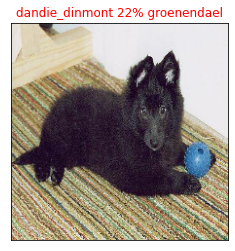

In [66]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_image,
          n=77)

Now we 've got one function to visualize our model predictions, let's make another to view our model top 10 predictions

The function will:
* Take an input of prediction probablities array and a ground truth array and an integer
* Find the prediction using 'get_pred_label()'
* Find the top 10:
  * Prediction probablities indexes.
  * Prediction probablities values.
  * Prediction labels
* Plot the top 10 Prediction probability values and labels,coloring the true label green


In [67]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the prediction label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change  of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

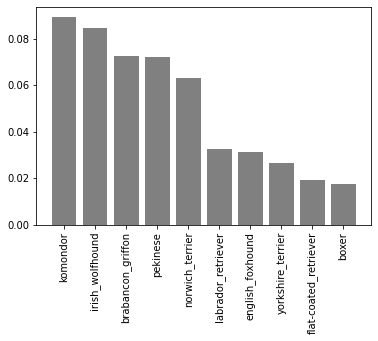

In [68]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)


Now we've got some function to help us visualize  our prediction and evaluate our model , let's check out a few.



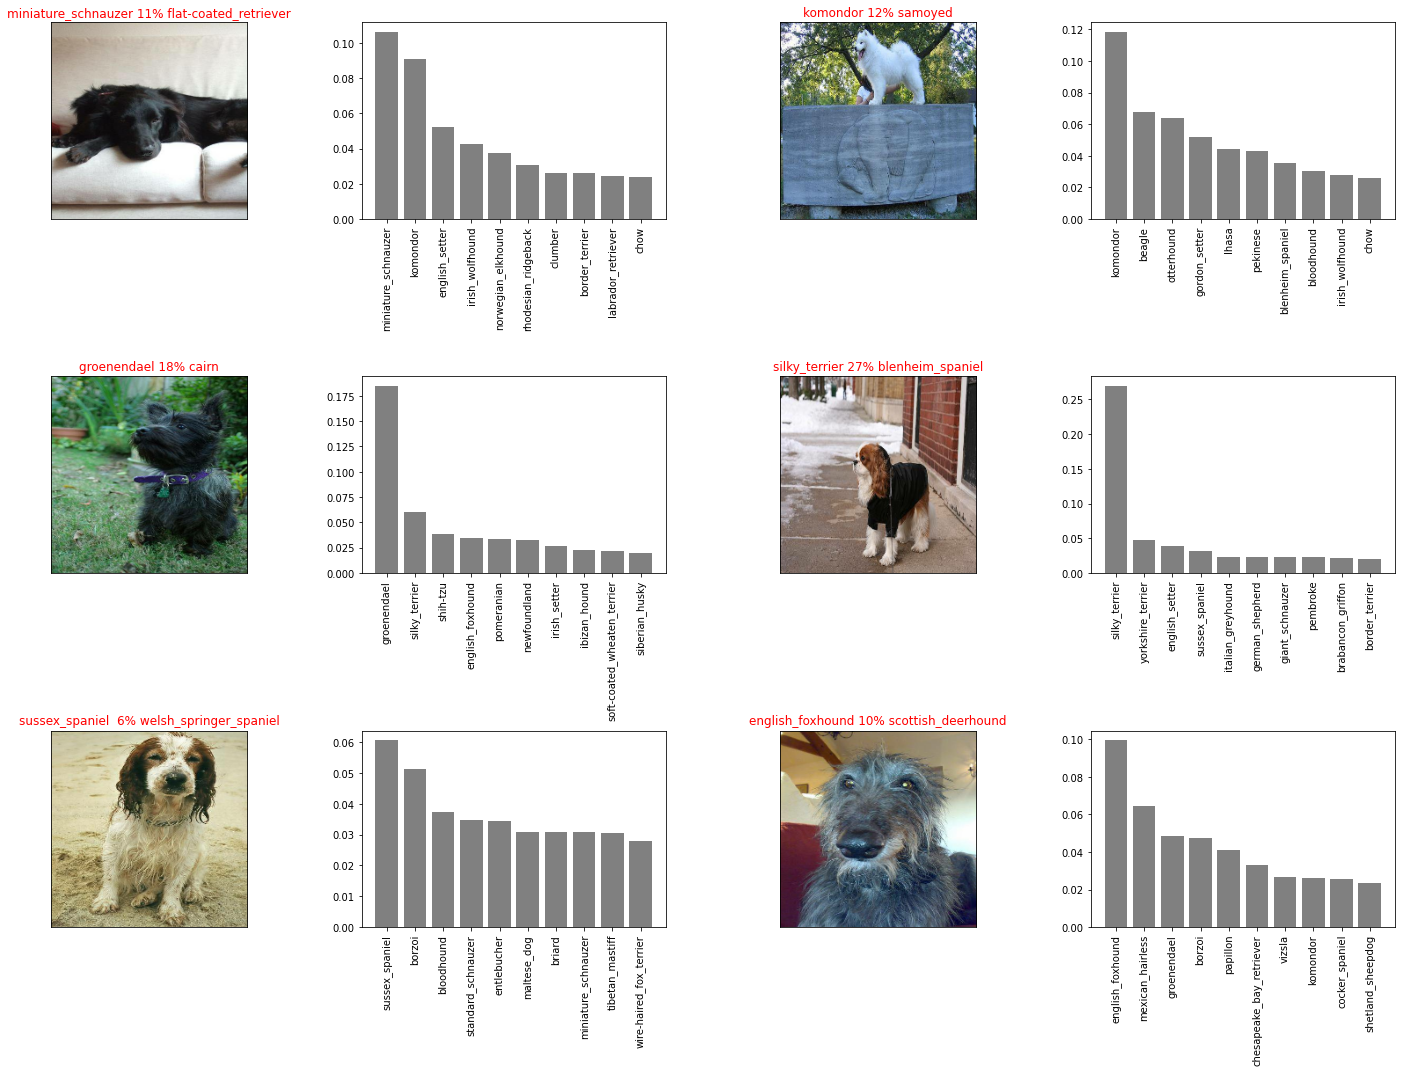

In [69]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols,2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_image,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0) 
plt.show()
  

** Challenge** How would you create confusion matrix with our model predictions and true label

# Save and reloading a trained model

In [70]:
# Create a function to save a model
def save_model(model,suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string)
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "_" + suffix + ".h5" # Save format of the model
  print(f"Saving model to :{model_path}...")
  model.save(model_path)
  return model_path

In [71]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loada a saved model from specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model , let,s make sure they work!


In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")


Saving model to :drive/My Drive/Dog Vision/models/20200629-04111593403896_1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200629-04111593403896_1000-images-mobilenetv2-Adam.h5'

In [72]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20200628-11261593343589_1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200628-11261593343589_1000-images-mobilenetv2-Adam.h5


In [73]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 156ms/step - loss: 5.9706 - accuracy: 0.0000e+00


[5.970639705657959, 0.0]

In [74]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 1s 155ms/step - loss: 1.2601 - accuracy: 0.6650


[1.2600898742675781, 0.6650000214576721]

In [ ]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil 
# !pip install humanize

# For checking GPU

# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()

# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#   process = psutil.Process(os.getpid())
#   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1b46f8f7bcba076fa9713b0e5d72ac0ab13823609c54e0e13a0989ab404823f6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.0 GB  | Proc size: 2.4 GB
GPU RAM Free: 3016MB | Used: 8425MB | Util  74% | Total 11441MB


# Training a big dog model (on the full data)

In [75]:
len(X), len(y)

(10222, 10222)

In [76]:
# Create a data batch with the full dataset 
full_data = create_data_batches(X,y)


Creating training data batches...


In [77]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [79]:
# Creat a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [78]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:**  Running the cell below will take a little while (maybe up to 30 min for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 5682s 18s/step - loss: 1.3449 - accuracy: 0.6725
Epoch 2/100
320/320 [==============================] - 67s 210ms/step - loss: 0.4058 - accuracy: 0.8809
Epoch 3/100
320/320 [==============================] - 67s 208ms/step - loss: 0.2366 - accuracy: 0.9359
Epoch 4/100
320/320 [==============================] - 67s 210ms/step - loss: 0.1528 - accuracy: 0.9623
Epoch 5/100
320/320 [==============================] - 67s 208ms/step - loss: 0.1074 - accuracy: 0.9782
Epoch 6/100
320/320 [==============================] - 66s 208ms/step - loss: 0.0760 - accuracy: 0.9884
Epoch 7/100
320/320 [==============================] - 67s 208ms/step - loss: 0.0586 - accuracy: 0.9911
Epoch 8/100
320/320 [==============================] - 67s 209ms/step - loss: 0.0478 - accuracy: 0.9934
Epoch 9/100
320/320 [==============================] - 68s 213ms/step - loss: 0.0375 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 67s 209m

In [ ]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

Saving model to :drive/My Drive/Dog Vision/models/20200629-06081593410901_full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200629-06081593410901_full-image-set-mobilenetv2-Adam.h5'

In [80]:
full_model = load_model('drive/My Drive/Dog Vision/models/20200629-06081593410901_full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200629-06081593410901_full-image-set-mobilenetv2-Adam.h5


In [81]:
full_model.evaluate(valid_data)

7/7 [==============================] - 1s 156ms/step - loss: 0.0044 - accuracy: 1.0000


[0.004412952344864607, 1.0]

## Making prediction on the test dataset 

Since our model has been trained on images in the form Tensor batches, to make predictions on the test data, we'll have to get into same format.

Luckily we created 'create_data_batches()' earlier which can take a list of filenames and cover them into Tensor batches.

To make prediction on the test data , we'll;
* Get the best image filenames
* Convert the filenames into test data batches using 'create_data_batches()' and setting the 'test_data' parameter to 'True ' (since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the predict() method callled on our model


In [82]:
# Load set image filename
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/f4e1d93f8d4f389547d69a5cd468e49d.jpg',
 'drive/My Drive/Dog Vision/test/f232ed4d2958c9b13ec8922933a852e4.jpg',
 'drive/My Drive/Dog Vision/test/ec0a814cc971dbe6e618a9a37ba355f8.jpg',
 'drive/My Drive/Dog Vision/test/ea6005562757cf5a7a37d70134d28870.jpg',
 'drive/My Drive/Dog Vision/test/e8c778896a73d0f6b4f88c564690c9db.jpg',
 'drive/My Drive/Dog Vision/test/ec6b4aee97cf7eeb6cb26540af933db2.jpg',
 'drive/My Drive/Dog Vision/test/f300694670b4219cf9e8f23306ae3407.jpg',
 'drive/My Drive/Dog Vision/test/e864f3fc5d19aec4b7a5aa547b359c57.jpg',
 'drive/My Drive/Dog Vision/test/eaf1a540a86c69877695a63ff9421be5.jpg',
 'drive/My Drive/Dog Vision/test/f1e0d9aa421de4c518baddf3d7bea598.jpg']

In [83]:
len(test_filenames)

10357

In [84]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [85]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

# Make predictions on test data batche using the loaded full model 
test_predictions = full_model.predict(test_data,
                                      verbose=1)

In [ ]:
test_predictions = full_model.predict(test_data,verbose=1)


In [ ]:
# Save predictions (Numpy array) to csv file (for access later)
# np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [86]:
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [87]:
test_predictions[:2]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, 1.40799395e-12,
        5.98032956e-09, 2.14533929e-11, 5.32851652e-10, 1.76493417e-10,
        4.49105718e-11, 1.84297355e-09, 5.29732508e-14, 6.22356655e-09,
        5.95073361e-13, 2.66395013e-08, 3.28688065e-15, 1.21886199e-11,
        1.19793180e-08, 2.38417955e-13, 4.40795955e-10, 3.99062901e-11,
        2.83421154e-13, 3.95438716e-12, 1.97962841e-10, 8.23695487e-11,
        1.06676962e-05, 1.19700536e-14, 9.42683501e-11, 6.76076625e-11,
        1.22097462e-11, 1.13671131e-05, 2.65428781e-12, 2.08955270e-10,
        3.13114146e-10, 2.81222046e-09, 4.10381153e-15, 1.54404389e-13,
        8.28562479e-12, 3.35177133e-12, 7.26731988e-13, 2.19305407e-11,
        2.61968953e-08, 2.37896139e-12, 9.63114245e-13, 4.27652705e-12,
        3.16920490e-10, 4.95381652e-11, 7.48146662e-13, 1.53999684e-13,
        1.32033314e-13, 5.06832687e-10, 1.54794150e-10, 9.16578554e-13,
        6.30603514e-10, 7.39330645e-12, 9.43311193e-11, 2.102985

## Preparing test dataset predictions for Kaggle

Looking at kaggle sample submittion , we find that it wants our models prediction probability output in a dataframe with an ID and a column for each different dog breeds.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll;
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to their ID column by extracting test image ID's from their filepaths.
* Add data(the prediction probabilities ) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to kaggle.



In [88]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [103]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df

'drive/My Drive/Dog Vision/test/'

In [106]:
# Append test image ID's to prediction DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [107]:
preds_df.head()

id  ... yorkshire_terrier
0  f4e1d93f8d4f389547d69a5cd468e49d  ...               NaN
1  f232ed4d2958c9b13ec8922933a852e4  ...               NaN
2  ec0a814cc971dbe6e618a9a37ba355f8  ...               NaN
3  ea6005562757cf5a7a37d70134d28870  ...               NaN
4  e8c778896a73d0f6b4f88c564690c9db  ...               NaN

[5 rows x 121 columns]

In [108]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f4e1d93f8d4f389547d69a5cd468e49d  ...       1.52162e-06
1  f232ed4d2958c9b13ec8922933a852e4  ...       2.56981e-10
2  ec0a814cc971dbe6e618a9a37ba355f8  ...       7.41861e-11
3  ea6005562757cf5a7a37d70134d28870  ...       6.13453e-11
4  e8c778896a73d0f6b4f88c564690c9db  ...       1.31887e-06

[5 rows x 121 columns]

In [109]:
# Save our prediction dataFrame to csv for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilnetV2.csv",
                index=False)

## Making prediction on custom image

To make prediction on custom images.
* Get the filepaths of our own images.
* Turn the filepaths into data batches using 'create_data_batches()'.And since our custom image won't have labels , we set the 'test_data' parameter to 'True'.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to prediction labels.
*  Compare the predicted labels to the custom images.

In [148]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/dog-photo/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [157]:
custom_image_path

['drive/My Drive/Dog Vision/dog-photo/images.jpeg',
 'drive/My Drive/Dog Vision/dog-photo/purebred-Lab-LS-long.jpg',
 'drive/My Drive/Dog Vision/dog-photo/Bulldog_02.jpg']

In [158]:
# Turn custom image into batch dataset
custom_data = create_data_batches(custom_image_path, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [159]:
# Make prediction on the custom data
custom_preds = full_model.predict(custom_data)


In [160]:
custom_preds.shape


(3, 120)

In [161]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['golden_retriever', 'labrador_retriever', 'american_staffordshire_terrier']

In [162]:
# Get custom images (our unbatchify () function won't work there aren't labels .. maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

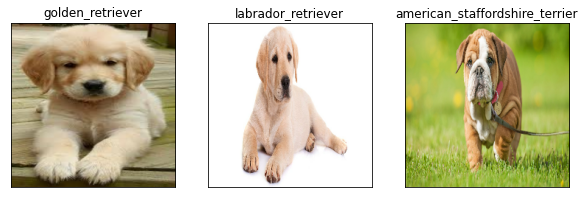

In [163]:
# Check custom image prediction 
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)